Several types of ophiolites. 
Subduction-unrelated (SU): continental margin type, mid-ocean ridge types, plume type.
Subduction-related (SR): suprasubduction zone types, volcanic arc types.
The transformation from lizardite to antigorite occur in the transition zone.
And retrograde metamorphism can compel the conversion of antigorite to lizardite/chrysotile.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, r2_score, make_scorer, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [2]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['font.size'] = 15

In [3]:
df_orig = pd.read_excel("Ophiolite.xlsx", sheet_name = 'Data')

In [4]:
df_orig.columns

Index(['Ref. ID', 'Publication Information', 'Locations', 'Period',
       'Mineralogy', 'TRUE VALUE', 'SiO2(wt.%)', 'TiO2(wt.%)', 'Al2O3(wt.%)',
       'Cr2O3(wt.%)', 'FeOtot(wt.%)', 'MnO(wt.%)', 'NiO(wt.%)', 'MgO(wt.%)',
       'CaO(wt.%)', 'Na2O(wt.%)', 'K2O(wt.%)'],
      dtype='object')

In [5]:
df = df_orig.drop(columns = [ 'Ref. ID', 'Publication Information', 'Locations',  
                              'Period', 'CaO(wt.%)', 'Na2O(wt.%)', 'K2O(wt.%)']).copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mineralogy    1375 non-null   object 
 1   TRUE VALUE    1375 non-null   int64  
 2   SiO2(wt.%)    1375 non-null   float64
 3   TiO2(wt.%)    1085 non-null   float64
 4   Al2O3(wt.%)   1349 non-null   float64
 5   Cr2O3(wt.%)   1221 non-null   float64
 6   FeOtot(wt.%)  1375 non-null   float64
 7   MnO(wt.%)     1266 non-null   float64
 8   NiO(wt.%)     1064 non-null   float64
 9   MgO(wt.%)     1375 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 107.5+ KB


In [6]:
df.Mineralogy.value_counts()

H_Srp    841
L_Srp    534
Name: Mineralogy, dtype: int64

In [7]:
from sklearn.model_selection import learning_curve
import matplotlib.ticker as mticker


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title, loc = 'left', fontsize = 15)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("(b). Scalability of the model", loc = 'left', fontsize = 15)

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("(c). Performance of the model", loc = 'left', fontsize = 15)

    return plt

In [8]:
random_state = 800

In [9]:
X = df.drop(columns = ['Mineralogy', 'TRUE VALUE']).copy()
y = df['TRUE VALUE'].copy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify = y, random_state = random_state)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((962, 8), (413, 8), (962,), (413,))

In [11]:
xg = XGBClassifier(objective='binary:logistic',
                   eval_metric = 'auc',
                   tree_method = 'hist',
                   n_estimators = 1000,
                   max_depth = 8,
#                    num_class = 3,
                   learning_rate = 0.2,
                   gamma = 0.30000000004,
                   seed = 800)

xg_result = xg.fit(X_train, y_train)
y_train_preds = xg.predict(X_train)
y_test_preds = xg.predict(X_test)

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = y_test_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.817     0.863     0.839       160
           1      0.910     0.877     0.893       253

    accuracy                          0.872       413
   macro avg      0.863     0.870     0.866       413
weighted avg      0.874     0.872     0.872       413



### Grid_Search

In [13]:
# xgb = XGBClassifier(objective = 'binary:logistic',
#                     eval_metric = 'auc',
#                     tree_method = 'hist',
#                     n_estimators = 1000,
#                     max_depth = 8,
#                     seed = 800)

# param_grid = {
# #     'max_depth' : np.arange(3, 9, 1),
#     'learning_rate' : np.arange(0, 0.5, 0.1),
# #     'alpha' : np.arange(0, 0.5, 0.1),
#     'gamma' : np.arange(0, 1, 0.1)
# }

# xgb_cv = GridSearchCV(xgb, param_grid = param_grid, cv = 5, scoring = 'accuracy', 
#                                  n_jobs = -1, verbose = 2)
# xgb_best = xgb_cv.fit(X_train, y_train)

In [14]:
# xgb_best.best_score_

In [15]:
# xgb_best.best_params_

In [16]:
# y_train_preds = xgb_best.predict(X_train)
# y_test_preds = xgb_best.predict(X_test)

In [17]:
# df_xgb = pd.DataFrame(xgb_best.cv_results_)

In [18]:
y_train_preds.shape, y_test_preds.shape

((962,), (413,))

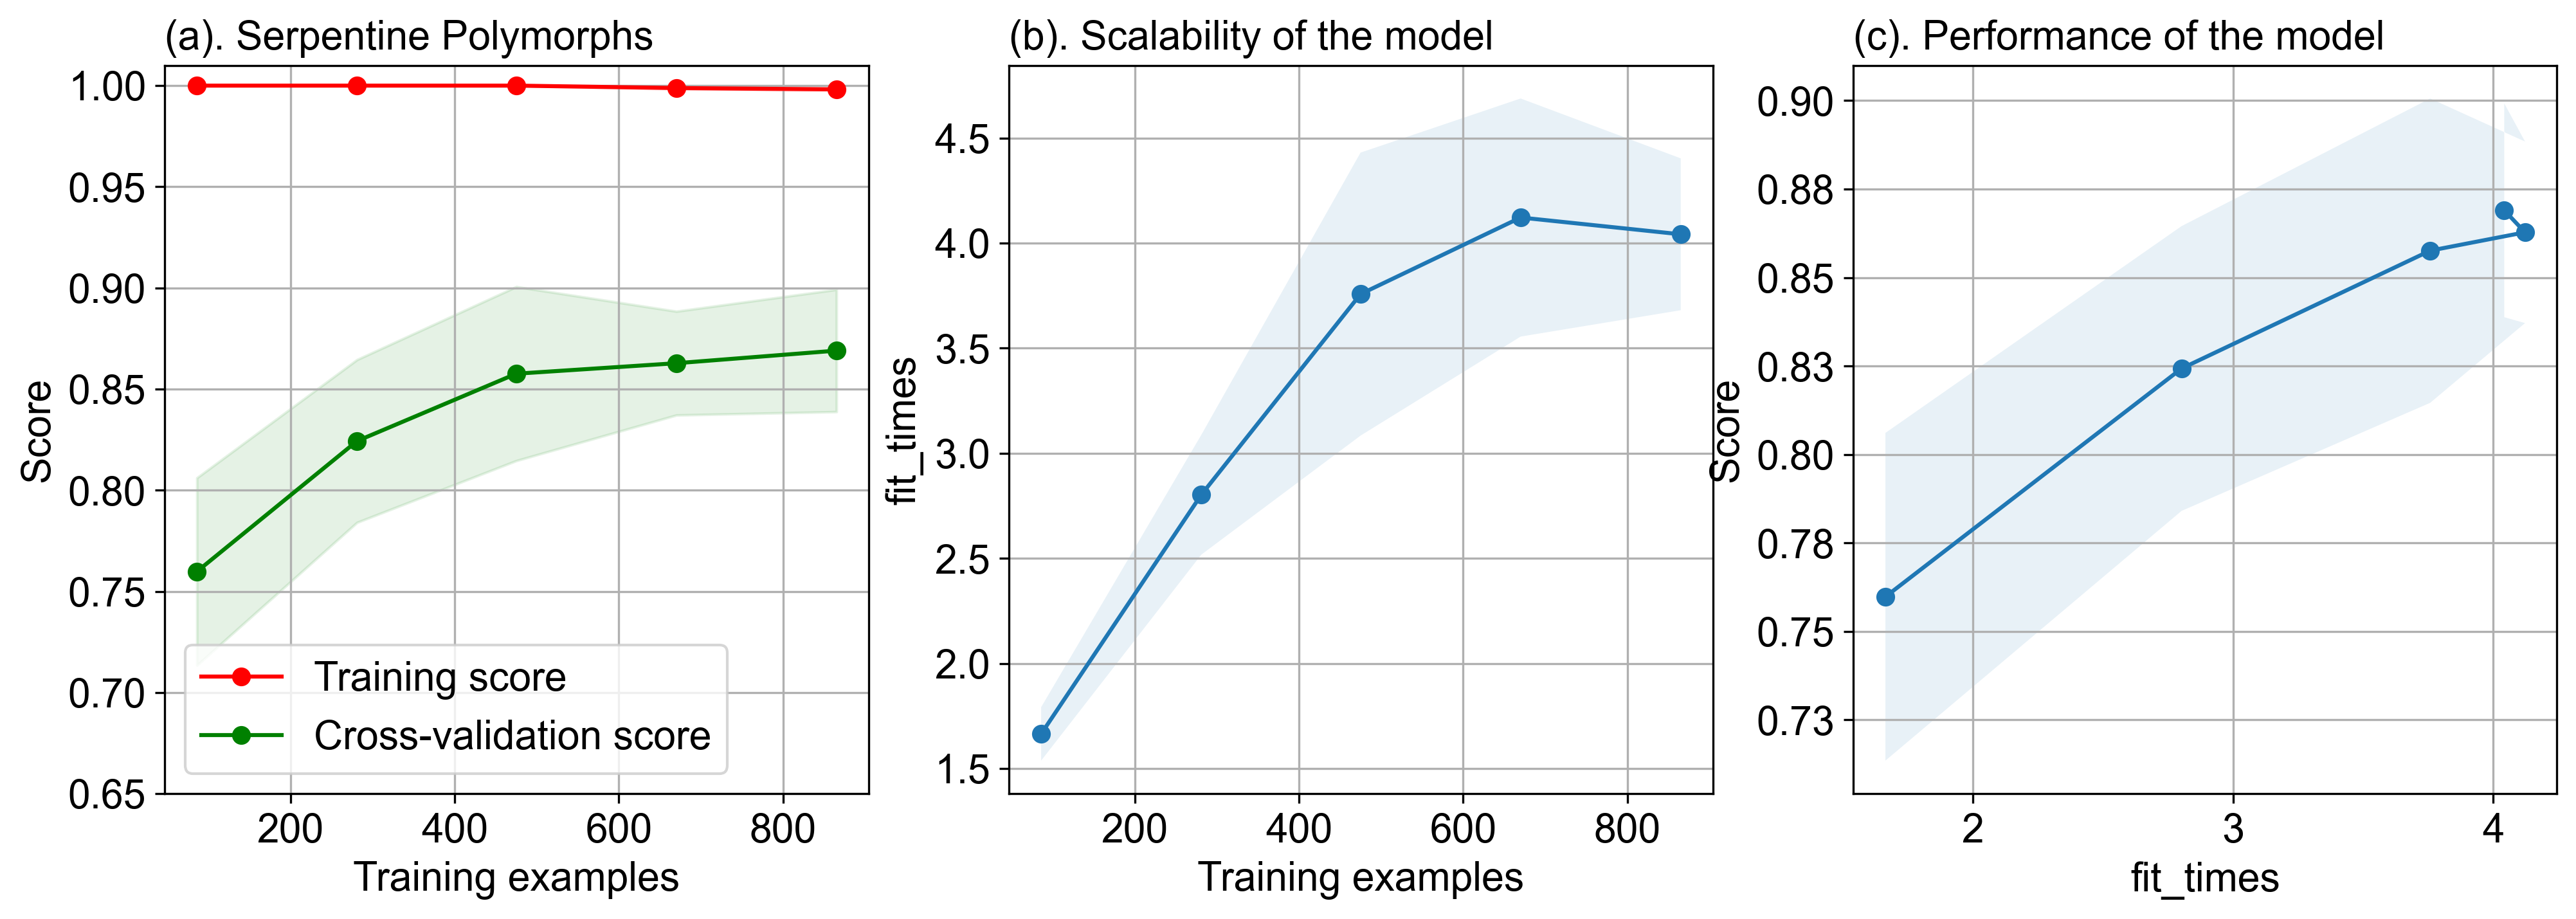

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi = 300)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

title = '(a). Serpentine Polymorphs'
plot_learning_curve(xg_result, title, X_train, y_train, axes = axes[:], 
                    ylim = (0.65, 1.01), cv = 10, n_jobs = -1)

plt.savefig('./Learning_Curve.png')

(a). Confusion matrix, without normalization
[[138  22]
 [ 31 222]]
(b). Normalized confusion matrix
[[0.8625     0.1375    ]
 [0.12252964 0.87747036]]


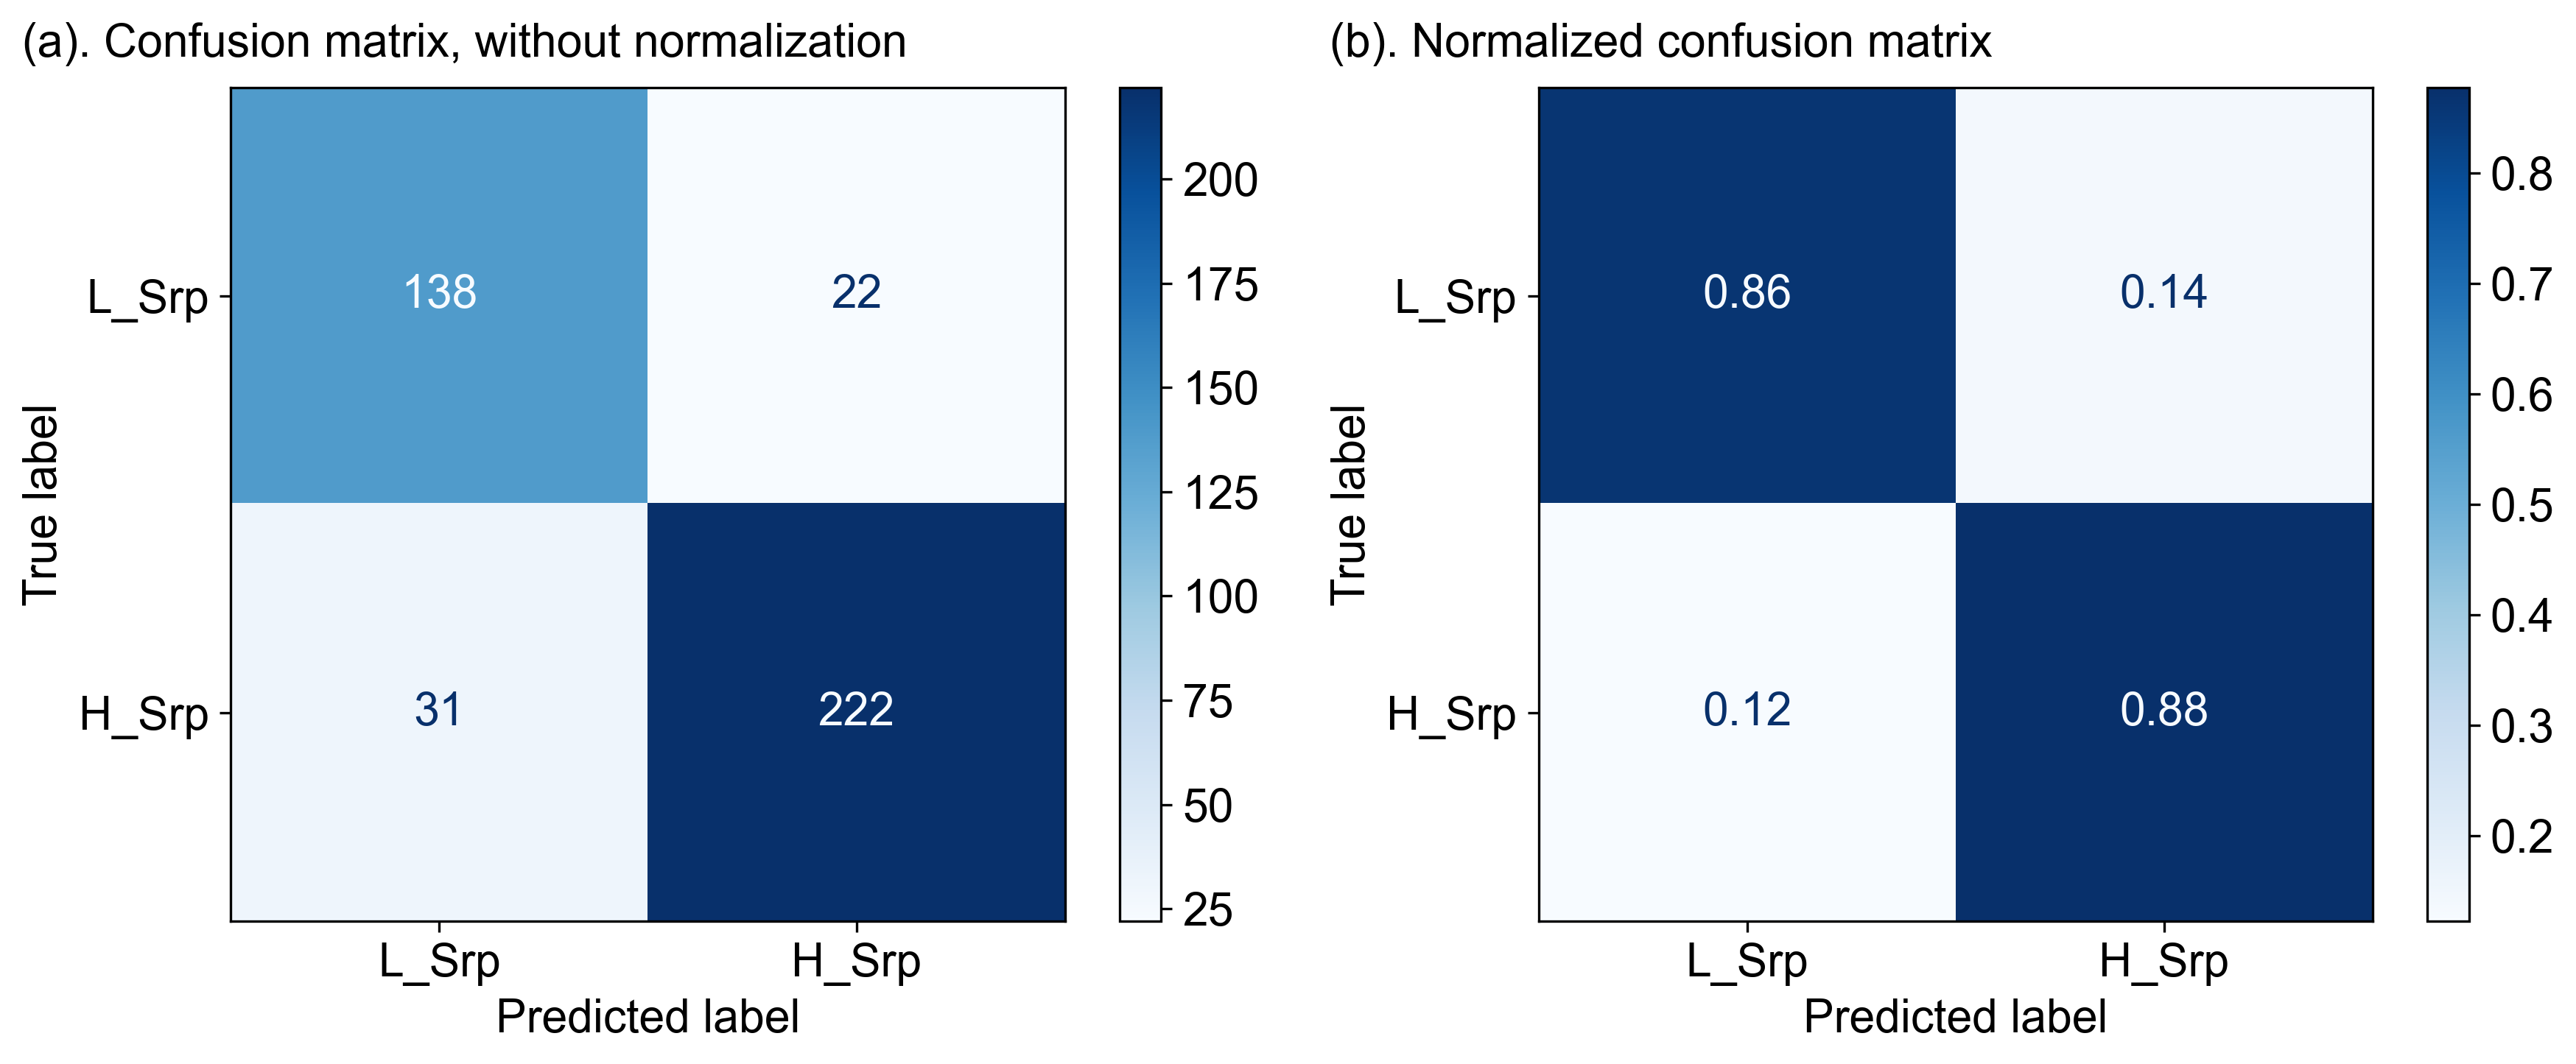

In [20]:
from sklearn.metrics import plot_confusion_matrix

figs, axs = plt.subplots(1, 2, figsize = (14, 5), dpi = 300)
titles_options = [("(a). Confusion matrix, without normalization", None, 0),
                  ("(b). Normalized confusion matrix", 'true', 1)]

for title, normalize, i in titles_options:
    disp = plot_confusion_matrix(xg_result, X_test, y_test,
                                 display_labels=['L_Srp', 'H_Srp'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                 ax = axs[i])
    disp.ax_.set_title(title, loc = 'left', fontsize = 15, x = -0.25, pad = 10)

    print(title)
    print(disp.confusion_matrix)
    
plt.savefig('./Confusion Matrix.png')

In [21]:
features = list(X.columns)
importances = xg_result.feature_importances_
indices = np.argsort(importances)
h = indices[::-1]

In [22]:
importances

array([0.2903779 , 0.08799179, 0.114351  , 0.06854176, 0.09156299,
       0.08993963, 0.1522644 , 0.10497051], dtype=float32)

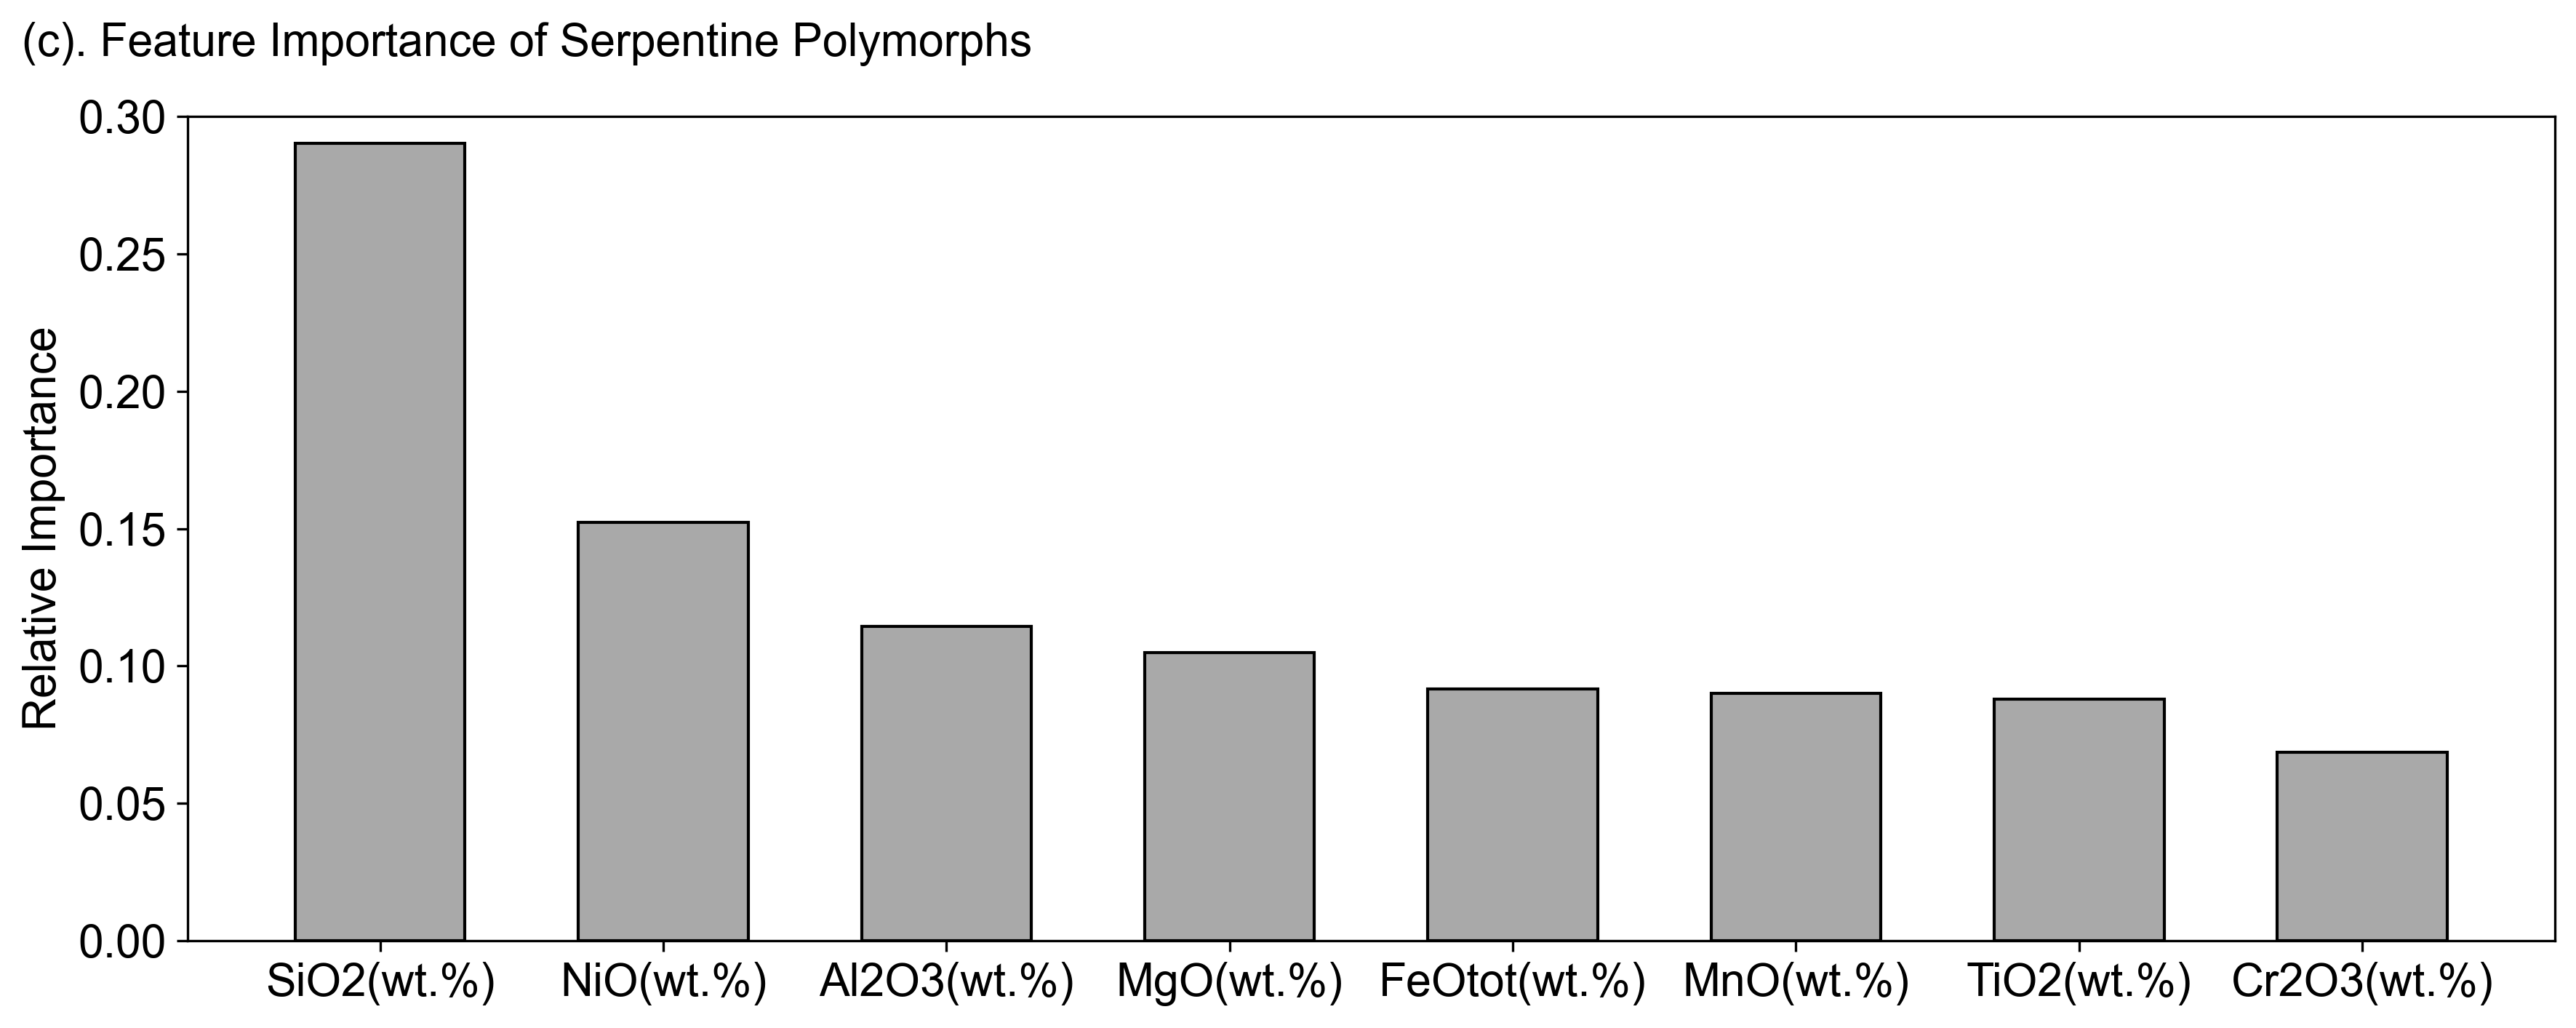

In [23]:
fig = plt.figure(figsize = (14, 5), dpi = 300)
plt.title('(c). Feature Importance of Serpentine Polymorphs', fontsize = 15, 
          loc = 'left', x = -0.07, pad = 20)

plt.tick_params(labelsize = 15)
plt.bar(x = range(len(h)), height = importances[h], width = 0.6, color='darkgray', 
        edgecolor = 'black', align='center')

plt.xticks(range(len(h)), [features[i] for i in h])
plt.ylabel('Relative Importance', fontsize = 15)
plt.ylim(0.0, 0.3)
plt.savefig('./Feature Importance')

Combination of predictions from training and test. Seems something wrong happens in the processes. For example, training dataset should be all used to trained the model which should not give any kind of evaluation results but just a model. The test dataset followed are applied to the model and will lead to some evaluation. That is why the step of combination of predictions from the training and test steps stupid and wrong.

In [24]:
# Y_train_preds = pd.DataFrame(y_train_preds, columns = ['y_preds'])
# Y_test_preds = pd.DataFrame(y_test_preds, columns = ['y_preds'])

# y_preds = pd.concat([Y_train_preds, Y_test_preds], ignore_index = True, axis = 0)

In [25]:
# Mineralogy_preds = []

# for i in np.arange(0, 1375):
#     if y_preds['y_preds'][i] == 0:        
#         Mineralogy_preds.append('L_Srp')
#     elif y_preds['y_preds'][i] == 1:
#         Mineralogy_preds.append('H_Srp')


# Mineralogy_preds = pd.DataFrame(Mineralogy_preds, columns = ['Mineralogy_preds'])
# df_preds = pd.concat([df_orig, y_preds, Mineralogy_preds], axis = 1)

In [26]:
# fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi = 300)
# plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# title = r"(a). Three Serpentine Polymorphs ($\gamma=0.04$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# plot_learning_curve(xg_result, title, X_train, y_train, axes = axes[:], ylim=(0.65, 1.01),
#                     cv=10, n_jobs=-1)

# plt.show()

In [27]:
# column_names = ['Ref. ID', 'Publication Information', 'Sampling Position', 'Locations', 'Types', 
#                 'Temperature', 'Pressure(kbar)', 'Conditions', 'Epoch', 'Period', 'Age(Ma)', 'Mineralogy', 
#                 'TRUE VALUE', 'SiO2(wt.%)', 'TiO2(wt.%)', 'Al2O3(wt.%)', 'Cr2O3(wt.%)', 
#                 'FeOtot(wt.%)', 'MnO(wt.%)', 'NiO(wt.%)', 'MgO(wt.%)', 'y_preds', 'Mineralogy_preds']

In [28]:
# df_true = pd.DataFrame(columns = column_names)
# df_wrong = df_true.copy()

# for i in np.arange(0, 1375):
#     if df_preds['Mineralogy'][i] == df_preds['Mineralogy_preds'][i]:
#         df_true = df_true.append([df_preds.iloc[i, :]], ignore_index = True)
#     else:
#         df_wrong = df_wrong.append([df_preds.iloc[i, :]], ignore_index = True)

In [29]:
# with pd.ExcelWriter('Ophiolite.xlsx', engine = 'openpyxl', mode = 'a') as writer:
#     df_true.to_excel(writer, sheet_name = 'true', float_format = '%.2f', index = False)
#     df_wrong.to_excel(writer, sheet_name = 'wrong', float_format = '%.2f', index = False)